In [2]:
import sympy
from sympy import symbols, lambdify, Rational
from matplotlib.lines import Line2D  # para leyenda personalizada
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Variables simbólicas
c, s = symbols('c s')
rc, rs, rd, alpha, delta, beta, a, gamma, eta, mu = symbols(
    'rc rs rd alpha delta beta a gamma eta mu'
)



params = {
  rc: 0.01,
  rs: 0.013,
  rd:  0.011,
  alpha: 0.81,
  delta: 0.82,
  beta: 1.0,
  a: 0.7,
  gamma: 0.74,
  eta: 5.08,
  mu: 0
}

In [4]:
# Funciones simbólicas
F1 = Rational(1, 4) * c * (
    - (4 * (a - c) * (-1 + c) * rc) / (-1 + a)
    - 4 * s**2 * alpha
    - (beta * (2 * rd + 2 * s**2 * delta - c**2 * (2 * eta + beta * mu))**2) / rd**2
    - 4 * mu * (
        s**2 * gamma + 
        (eta * (2 * rd + 2 * s**2 * delta - c**2 * (2 * eta + beta * mu))**2) / (4 * rd**2)
    )
)


# Expresión simbólica
F2 = Rational(1, 4) * s * (
    -4 * rs * (-1 + s)
    - 4 * c**2 * gamma
    - 2 * c**2 * alpha * mu
    + (delta * (2 * rd + 2 * s**2 * delta - c**2 * (2 * eta + beta * mu))**2) / rd**2
)

In [9]:
# Sustitución de parámetros
F1_eval = F1.subs(params)
F2_eval = F2.subs(params)

# Lambdify para evaluación numérica
f1 = lambdify((c, s), F1_eval, modules='numpy')
f2 = lambdify((c, s), F2_eval, modules='numpy')

# Malla para graficar
C, S = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
U = f1(C, S)
V = f2(C, S)

# Calcular curvas nulas e intersecciones aproximadas
f1_vals = np.abs(U)
f2_vals = np.abs(V)
tolerance = 0.01
mask_eq = (f1_vals < tolerance) & (f2_vals < tolerance)
eq_points = np.column_stack((C[mask_eq], S[mask_eq]))

/tmp/ipykernel_14329/3548610276.py:35: UserWarning: No contour levels were found within the data range.
  contour_f1 = ax.contour(C, S, U, levels=[0], colors='black', linewidths=2)


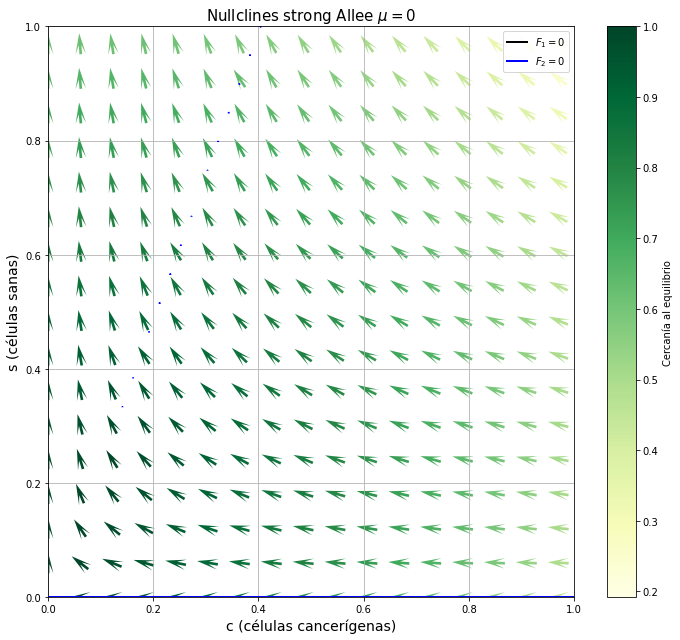

In [10]:
# Ajustar densidad de flechas
step = 6  # más alto = menos flechas

# Normalizar vectores
magnitude = np.sqrt(U**2 + V**2)
U_norm = U / (magnitude + 1e-8)
V_norm = V / (magnitude + 1e-8)

# Calcular intensidad de color según cercanía a nullclinas
if eq_points.shape[0] > 0:
    dist = np.min([np.sqrt((C - x)**2 + (S - y)**2) for x, y in eq_points], axis=0)
    color_intensity = 1 - dist / np.max(dist)
    color_intensity = np.sqrt(color_intensity)  # suavizar contraste
else:
    color_intensity = np.ones_like(C)

# Crear figura
fig, ax = plt.subplots(figsize=(10, 9))

# Campo vectorial con flechas coloreadas
quiv = ax.quiver(C[::step, ::step], S[::step, ::step],
                 U_norm[::step, ::step], V_norm[::step, ::step],
                 color_intensity[::step, ::step],
                 cmap='YlGn',
                 pivot='middle',
                 scale=25,
                 width=0.006,
                 headwidth=4,
                 headlength=8)

# Barra de color asociada a las flechas
cbar = plt.colorbar(quiv, ax=ax, label='Cercanía al equilibrio')

# Nullclines
contour_f1 = ax.contour(C, S, U, levels=[0], colors='black', linewidths=2)
contour_f2 = ax.contour(C, S, V, levels=[0], colors='blue', linewidths=2)

# Leyenda
legend_elements = [
    Line2D([0], [0], color='black', lw=2, label='$F_1 = 0$'),
    Line2D([0], [0], color='blue', lw=2, label='$F_2 = 0$')
]
ax.legend(handles=legend_elements)

# Estética final
ax.set_xlabel('c (células cancerígenas)', fontsize=14)
ax.set_ylabel('s (células sanas)', fontsize=14)
ax.set_title('Nullclines strong Allee $\mu = 0$', fontsize=15)
ax.grid(True)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()


In [12]:
def newton_raphson(f1, f2, x0, y0, tol=1e-6, max_iter=100):
    x, y = x0, y0

    for _ in range(max_iter):
        try:
            # Derivadas numéricas (diferencias finitas)
            J11 = (f1(x + tol, y) - f1(x, y)) / tol
            J12 = (f1(x, y + tol) - f1(x, y)) / tol
            J21 = (f2(x + tol, y) - f2(x, y)) / tol
            J22 = (f2(x, y + tol) - f2(x, y)) / tol
            J = np.array([[J11, J12], [J21, J22]])
            F_val = np.array([f1(x, y), f2(x, y)])

            if np.linalg.cond(J) > 1e12:
                return None, None

            delta = np.linalg.solve(J, F_val)

            x -= delta[0]
            y -= delta[1]

            if np.linalg.norm(delta) < tol:
                return x, y
        except:
            return None, None

    return None, None  # no convergió

In [13]:
# Suposición inicial
c0 = 0
s0 = 0

# Encontrar las soluciones
c_sol, s_sol = newton_raphson(f1, f2, c0, s0)

In [14]:
c_sol

0.0

In [15]:
s_sol

0.0

In [16]:
# Suposición inicial 2
c1 = 2.7
s1 = 1.5
c_sol, s_sol = newton_raphson(f1, f2, c1, s1)

In [17]:
c_sol

5.7876558896147935e-15

In [18]:
s_sol

-6.4780326476081426e-15